# Sommaire
1. [Importation des librairies et chargement des données](#0-bullet) <br>
2. [Démarrer la session spark](#1-bullet) <br>
3. [Chargement des données](#2-bullet) <br>
    1. [En local](#3-bullet) <br>      
    2. [Via le cloud (AWS S3)](#4-bullet) <br>     
4. [Préparation du modèle  du Model ( MobileNetV2)](#5-bullet) <br>
5. [Prétraitement des images et Extraction des features](#6-bullet) <br>
6. [Standardisation des features](#7-bullet) <br>
7. [Réduction de dimension : PCA](#8-bullet) <br>
8. [Sauvegarde des features](#9-bullet) <br>
9. [Arrêt de la session Spark](#10-bullet) <br>


## 1. Importation des librairies et chargement des données<a class="anchor" id="0-bullet"></a>

In [1]:
# librairies classiques

import pandas as pd
from PIL import Image
import numpy as np
import io
import os
import matplotlib.pyplot as plt
import warnings # supress warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession


# librairies pyspark
from pyspark.sql.functions import PandasUDFType
from pyspark.sql.types import IntegerType

from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector

from pyspark.ml.feature import StandardScaler, PCA

# Installation d'Hadoop Spark
#import findspark
#findspark.init('/desktop/spark-3.0.3-bin-hadoop2.7')

2022-12-06 22:02:14.369540: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Démarrer la session spark<a class="anchor" id="1-bullet"></a>

In [2]:
spark = (SparkSession
             .builder
             .appName('P8')
             .master('local')
             #.master('AWS')
             #.config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:2.7")
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/06 22:02:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
sc = spark.sparkContext

In [4]:
sc.setLogLevel("FATAL")
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [5]:
spark

## 3. Chargement des données<a class="anchor" id="2-bullet"></a>

### 1. En local<a class="anchor" id="3-bullet"></a>

In [6]:
PATH = os.getcwd()
PATH_Data = PATH+'/fruits_aws/'
PATH_Result = PATH+'/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

PATH:        /Users/Gucci/Desktop/P8
PATH_Data:   /Users/Gucci/Desktop/P8/fruits_aws/
PATH_Result: /Users/Gucci/Desktop/P8/Results


In [7]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

### 2. Via le cloud (AWS S3)<a class="anchor" id="4-bullet"></a>

In [8]:
#NAME_BUCKET = 'ocp8gr'

In [9]:
#s3_url = f's3://{NAME_BUCKET}'

In [10]:
#PATH = 's3_url'
#PATH_Data = PATH+'/fruits_aws'
#PATH_Result = PATH+'/Results'
#print('PATH:        '+\
#      PATH+'\nPATH_Data:   '+\
#      PATH_Data+'\nPATH_Result: '+PATH_Result)

In [11]:
#images= (spark.read.format('binaryFile')
#       .option("pathGlobFilter", "*.jpg")
#       .option("recursiveFileLookup", "true")
#       .load(s3_url))

In [12]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+---------------------------------------------------------------------+------------------+
|path                                                                 |label             |
+---------------------------------------------------------------------+------------------+
|file:/Users/Gucci/Desktop/P8/fruits_aws/Apple Crimson Snow/84_100.jpg|Apple Crimson Snow|
|file:/Users/Gucci/Desktop/P8/fruits_aws/Apple Crimson Snow/80_100.jpg|Apple Crimson Snow|
|file:/Users/Gucci/Desktop/P8/fruits_aws/Apple Crimson Snow/83_100.jpg|Apple Crimson Snow|
|file:/Users/Gucci/Desktop/P8/fruits_aws/Kiwi/6_100.jpg               |Kiwi              |
|file:/Users/Gucci/Desktop/P8/fruits_aws/Apple Crimson Snow/81_100.jpg|Apple Crimson Snow|
+-------------------------------------------------------------

In [13]:
images.count()

20

## 4. Préparation du modèle  du Model ( MobileNetV2)<a class="anchor" id="5-bullet"></a>

In [14]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

2022-12-06 22:02:31.499598: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
new_model = Model(inputs=model.input, outputs=model.layers[-2].output)

In [16]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [17]:
brodcast_weights = sc.broadcast(new_model.get_weights())

## 5.Prétraitement des images et Extraction des features<a class="anchor" id="6-bullet"></a>

In [18]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

In [19]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


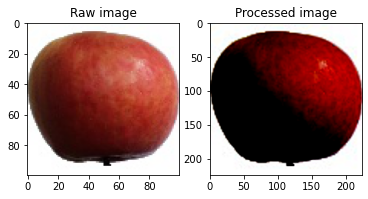

In [20]:
# Show preprocess effect on image
img = images.first()["content"]
fig, axs = plt.subplots(1, 2)
axs[0].imshow(Image.open(io.BytesIO(img)))
axs[0].set_title('Raw image')
axs[1].imshow(preprocess(img))
axs[1].set_title('Processed image')
plt.show()

In [21]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

In [22]:
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

In [23]:
# création d'UDF qui transforme chaque ligne vers un vecteur
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())

In [24]:
# appliquer "featurize_udf" sur tout le dataframe
features_df = images.repartition(16).select(col('path'), featurize_udf('content').alias('features'))
# appliquer "list_to_vector_udf" sur tout le dataframe
features_df = features_df.withColumn("features_udf", list_to_vector_udf(col("features")))

In [25]:
features_df.show()

2022-12-06 22:02:38.131362: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 22:02:43.562604: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
1/1 [==============================] - 1s 781ms/step====>          (9 + 1) / 11]


+--------------------+--------------------+--------------------+
|                path|            features|        features_udf|
+--------------------+--------------------+--------------------+
|file:/Users/Gucci...|[0.9761678, 0.0, ...|[0.97616779804229...|
|file:/Users/Gucci...|[0.3310693, 0.0, ...|[0.33106929063796...|
|file:/Users/Gucci...|[1.5691199, 0.0, ...|[1.56911993026733...|
|file:/Users/Gucci...|[0.39133763, 0.0,...|[0.39133763313293...|
|file:/Users/Gucci...|[1.5477298, 0.0, ...|[1.54772984981536...|
|file:/Users/Gucci...|[0.38478822, 0.0,...|[0.38478821516036...|
|file:/Users/Gucci...|[1.0014192, 0.010...|[1.00141918659210...|
|file:/Users/Gucci...|[1.4642531, 0.0, ...|[1.46425306797027...|
|file:/Users/Gucci...|[1.5605391, 0.0, ...|[1.56053912639617...|
|file:/Users/Gucci...|[1.2494104, 0.0, ...|[1.24941039085388...|
|file:/Users/Gucci...|[0.11115312, 0.0,...|[0.11115311831235...|
|file:/Users/Gucci...|[1.0829992, 0.006...|[1.08299922943115...|
|file:/Users/Gucci...|[0.

1/1 [==============================] - 1s 784ms/step


## 6.Standardisation des features<a class="anchor" id="7-bullet"></a>

In [26]:
scaler = StandardScaler(
    inputCol="features_udf", 
    outputCol="features_scaled")

data_scaled = scaler.fit(features_df).transform(features_df)

1/1 [==============================] - 1s 796ms/step==========>   (15 + 1) / 16]


In [27]:
data_scaled.show()

1/1 [==============================] - 1s 785ms/step====>          (9 + 1) / 11]


+--------------------+--------------------+--------------------+--------------------+
|                path|            features|        features_udf|     features_scaled|
+--------------------+--------------------+--------------------+--------------------+
|file:/Users/Gucci...|[0.9761678, 0.0, ...|[0.97616779804229...|[2.00313887785069...|
|file:/Users/Gucci...|[0.3310693, 0.0, ...|[0.33106929063796...|[0.67936861743377...|
|file:/Users/Gucci...|[1.5691199, 0.0, ...|[1.56911993026733...|[3.21990250306605...|
|file:/Users/Gucci...|[0.39133763, 0.0,...|[0.39133763313293...|[0.80304188364620...|
|file:/Users/Gucci...|[1.5477298, 0.0, ...|[1.54772984981536...|[3.17600912547296...|
|file:/Users/Gucci...|[0.38478822, 0.0,...|[0.38478821516036...|[0.78960219244306...|
|file:/Users/Gucci...|[1.0014192, 0.010...|[1.00141918659210...|[2.05495582799520...|
|file:/Users/Gucci...|[1.4642531, 0.0, ...|[1.46425306797027...|[3.00471112993662...|
|file:/Users/Gucci...|[1.5605391, 0.0, ...|[1.56053912

1/1 [==============================] - 1s 801ms/step


## 7.Réduction de dimension : PCA<a class="anchor" id="8-bullet"></a>

In [28]:
#entrainement de l'algorithme PCA
pca = PCA(k=1000, inputCol="features_scaled", outputCol="features_reduced")
model_pca = pca.fit(data_scaled)
data_final = model_pca.transform(data_scaled)

1/1 [==============================] - 1s 874ms/step==========>   (15 + 1) / 16]


La variance expliquée égale a 99% est vérifiée avec 16 composantes


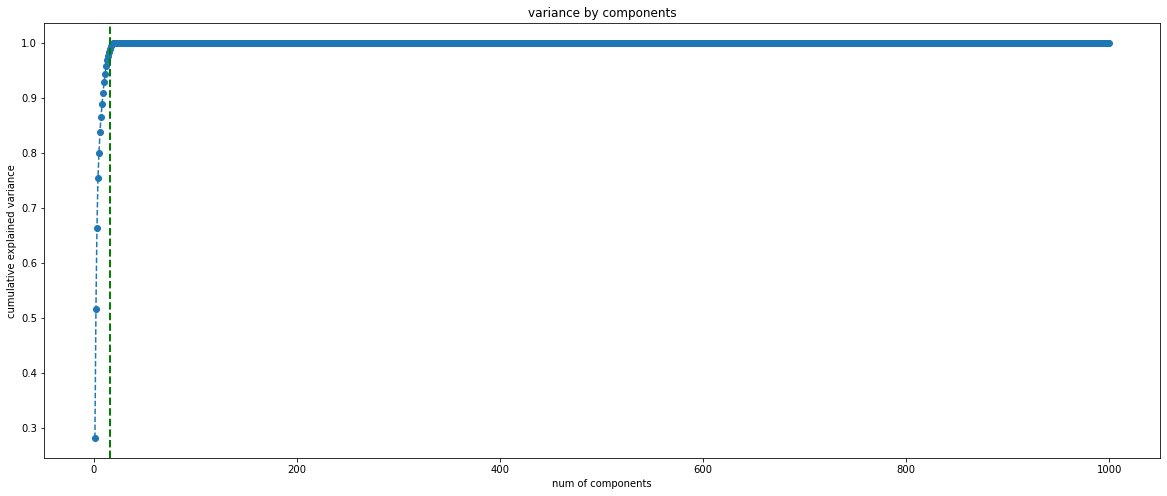

In [29]:
# Calcul de la variance expliquée cumulée par les composantes
cumValues = model_pca.explainedVariance.cumsum() # get the cumulative values

# fixer le seuil de variance expliqué minimal
seuil = 99

# afficher le graphe pour décider du nombre de composantes à considérer

plt.figure(figsize=(20,8))
plt.plot(range(1,1001), cumValues, marker = 'o', linestyle='--')

X_idx = np.where(cumValues*100 >= seuil)[0]
nb_composante = X_idx[cumValues[X_idx].argmin()]
plt.axvline(x=nb_composante, linestyle="--", color="green",linewidth=2)

plt.title('variance by components')
plt.xlabel('num of components')
plt.ylabel('cumulative explained variance')


print(f"La variance expliquée égale a {seuil}% est vérifiée avec {nb_composante} composantes")

In [30]:
#entrainement de l'algorithme PCA
pca = PCA(k=nb_composante, inputCol="features_scaled", outputCol="features_reduced")
model_pca = pca.fit(data_scaled)
data_final = model_pca.transform(data_scaled)

1/1 [==============================] - 1s 827ms/step==========>   (15 + 1) / 16]


In [31]:
data_final = data_final.select(col('path'), col('features_reduced'))

In [32]:
data_final.show()

1/1 [==============================] - 1s 786ms/step====>          (9 + 1) / 11]


+--------------------+--------------------+
|                path|    features_reduced|
+--------------------+--------------------+
|file:/Users/Gucci...|[4.05633130879953...|
|file:/Users/Gucci...|[5.08342800218017...|
|file:/Users/Gucci...|[-37.206174015289...|
|file:/Users/Gucci...|[9.14298516942701...|
|file:/Users/Gucci...|[4.16418798257432...|
|file:/Users/Gucci...|[4.24094738052665...|
|file:/Users/Gucci...|[8.64319229866849...|
|file:/Users/Gucci...|[-39.004455150990...|
|file:/Users/Gucci...|[-36.086459352749...|
|file:/Users/Gucci...|[4.25494474412681...|
|file:/Users/Gucci...|[9.78288109049947...|
|file:/Users/Gucci...|[8.33134547782142...|
|file:/Users/Gucci...|[3.90569820922017...|
|file:/Users/Gucci...|[4.73810409830349...|
|file:/Users/Gucci...|[3.97517725600326...|
|file:/Users/Gucci...|[8.88519960179094...|
|file:/Users/Gucci...|[-39.313235151468...|
|file:/Users/Gucci...|[8.60444173565708...|
|file:/Users/Gucci...|[9.16468184098250...|
|file:/Users/Gucci...|[9.7749702

1/1 [==============================] - 1s 790ms/step


## 8.Sauvegarde des features <a class="anchor" id="9-bullet"></a>

In [33]:
#Sauvegarde des résultats au format parquet
data_final.write.mode("overwrite").parquet(PATH_Result)

1/1 [==============================] - 1s 804ms/step==========>   (15 + 1) / 16]


In [34]:
#Sauvegarde des résultats au format csv
data_final = data_final.write.mode("overwrite").parquet(PATH_Result)
#data_final.to_csv('Results.csv')

In [35]:
#Visualisation des résultats via PyArrow
#df = pd.read_parquet(PATH_Result, engine='pyarrow')

In [36]:
#df.head()

,path,features_reduced
0,file:/Users/Gucci/Desktop/P8/fruits_aws/Kiwi/5...,"{'type': 1, 'size': None, 'indices': None, 'va..."
1,file:/Users/Gucci/Desktop/P8/fruits_aws/Avocad...,"{'type': 1, 'size': None, 'indices': None, 'va..."
2,file:/Users/Gucci/Desktop/P8/fruits_aws/Banana...,"{'type': 1, 'size': None, 'indices': None, 'va..."
3,file:/Users/Gucci/Desktop/P8/fruits_aws/Apple ...,"{'type': 1, 'size': None, 'indices': None, 'va..."
4,file:/Users/Gucci/Desktop/P8/fruits_aws/Kiwi/3...,"{'type': 1, 'size': None, 'indices': None, 'va..."


## 9.Arrêt de la session Spark <a class="anchor" id="10-bullet"></a>

In [39]:
spark.stop()